<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/Tema3_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tema 3.4. Construcción automática de modelos ARIMA: ```AutoARIMA()```

### ```statsforecast```

Una librería reciente y potente para construir modelos automáticamente es ```statsforecast```:  
https://nixtlaverse.nixtla.io/statsforecast/index.html

Ofrece una colección de modelos populares de predicción de series temporales univariantes (incluido el ARIMA) optimizados para un alto rendimiento y escalabilidad.

Leer esta guía [QUICK START](https://nixtlaverse.nixtla.io/statsforecast/docs/getting-started/getting_started_short.html).  

Como se indica en el enlace, el *input* de ```StatsForecast``` siempre es un dataframe en formato largo con tres columnas: ```unique_id```, ```ds``` e ```y```.

* La columna ```unique_id``` (*string*, entero o categoría) representa un identificador para la serie.

* La columna ```ds``` (*datestamp*) debe tener un formato compatible con Pandas, idealmente AAAA-MM-DD para las fechas/periodos.

* La columna ```y``` (numérica) representa la medición que se desea predecir.

### Instalación en Google Colab

Dado que la librería no viene pre-instalada en Google Colab, es necesario instalarla cada vez que abrimos una sesión en Google Colab. Esto toma unos segundos.

In [ ]:
pip install statsforecast

### Importar librerías y procesar datos

A continuación importamos la librería recien instalada, junto a la función AutoARIMA de manera separada, así como otras librerías que vamos a usar.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams["figure.figsize"] = [10,4]  # Default figure size
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

Importamos los datos usados en el notebook 3.5

In [9]:
medic = pd.read_csv("https://raw.githubusercontent.com/otoperalias/Coyuntura/main/clases/datos/medicamentos_ventas.csv",index_col=0,parse_dates=True)
visit = pd.read_excel("https://github.com/otoperalias/Coyuntura/raw/refs/heads/main/clases/datos/medic_visitas_doctor.xlsx", index_col=0, parse_dates=True)


Es necesario procesar la dataframe ligeramente para ponerla en el formato aceptado por StatsForecast:

In [16]:
medic["unique_id"]="ventas_medic"
medic["ds"]=medic.index
medic['y']=medic['value']
medic.drop(columns=['value'],inplace=True)
medic

,unique_id,ds,y
date,,,
1991-07-01,ventas_medic,1991-07-01,3.526591
1991-08-01,ventas_medic,1991-08-01,3.180891
1991-09-01,ventas_medic,1991-09-01,3.252221
1991-10-01,ventas_medic,1991-10-01,3.611003
1991-11-01,ventas_medic,1991-11-01,3.565869
...,...,...,...
2008-02-01,ventas_medic,2008-02-01,21.654285
2008-03-01,ventas_medic,2008-03-01,18.264945
2008-04-01,ventas_medic,2008-04-01,23.107677


Dividimos la serie en train y test dataset:

In [17]:
train=medic[:-24]
test=medic[-24:]

Se especifica y se estima el modelo (tarda unos segundos porque estima muchos modelos hasta encontrar el óptimo):

In [58]:
modelo = StatsForecast(models=[AutoARIMA(season_length=12)],freq='MS')  # Indicamos que son datos sin estacionalidad y la frecuencia es "months start"
modelo.fit(train)

StatsForecast(models=[AutoARIMA])

El *output* del modelo se puede observar como sigue:

In [59]:
print ("Especificación del modelo: ",modelo.fitted_[0,0].model_['arma'])
print ("Observations",modelo.fitted_[0,0].model_['nobs'])
print ("AIC: ",modelo.fitted_[0,0].model_['aic'])
print ("Coeficientes: ")
for x in modelo.fitted_[0,0].model_['coef']:
  print("  ", x, ":", modelo.fitted_[0,0].model_['coef'][x])

Especificación del modelo:  (2, 1, 0, 2, 12, 1, 1)
Observations 167
AIC:  320.49305607360407
Coeficientes: 
   ar1 : 0.016082095113216444
   ar2 : 0.312083467137868
   ma1 : -0.9228299412323577
   sma1 : -0.16048571691686386
   sma2 : -0.19190335043065251


In [33]:
forecast_df=modelo.predict(h=len(test), level=[95])
forecast_df # es una dataframe con la predicción y el IC

Dibujamos la predicción:

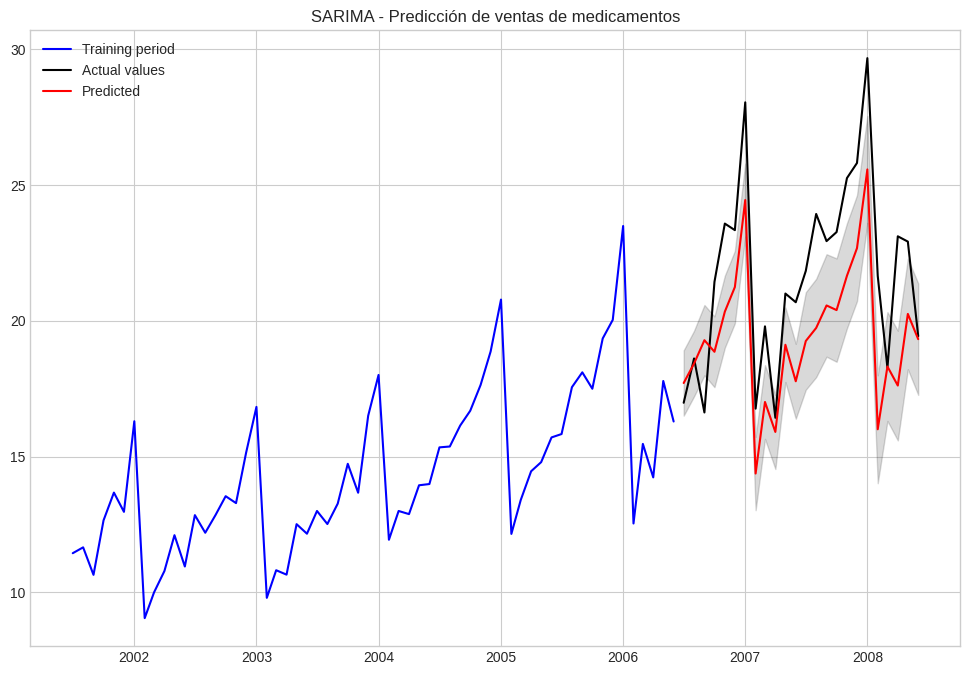

In [45]:
# Primero creo un index para forecast_df
forecast_df.set_index(forecast_df.ds, drop=False, inplace=True )

# Gráfico
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(train[-60:]['y'], label="Training period", color="b") #con [-60:] evito representar la serie completa
ax.plot(test['y'], label="Actual values", color="k")
ax.plot(forecast_df['AutoARIMA'], label="Predicted", color='r')
ax.fill_between(forecast_df.index,
                 forecast_df['AutoARIMA-lo-95'],
                 forecast_df['AutoARIMA-hi-95'],
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA - Predicción de ventas de medicamentos")
plt.show()

Comprobamos numéricamente la exactitud de la predicción:

In [48]:
def forecast_accuracy(forecast, actual):
    rmse = np.sqrt(np.mean((forecast-actual)**2))
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    print({'rmse':rmse,'mape':mape,'corr':corr})

forecast_accuracy(forecast_df['AutoARIMA'], test.y)

{'rmse': np.float64(2.9907840526348477), 'mape': np.float64(0.11579926204026743), 'corr': np.float64(0.8408751300344401)}


Predecimos también hacia el futuro:

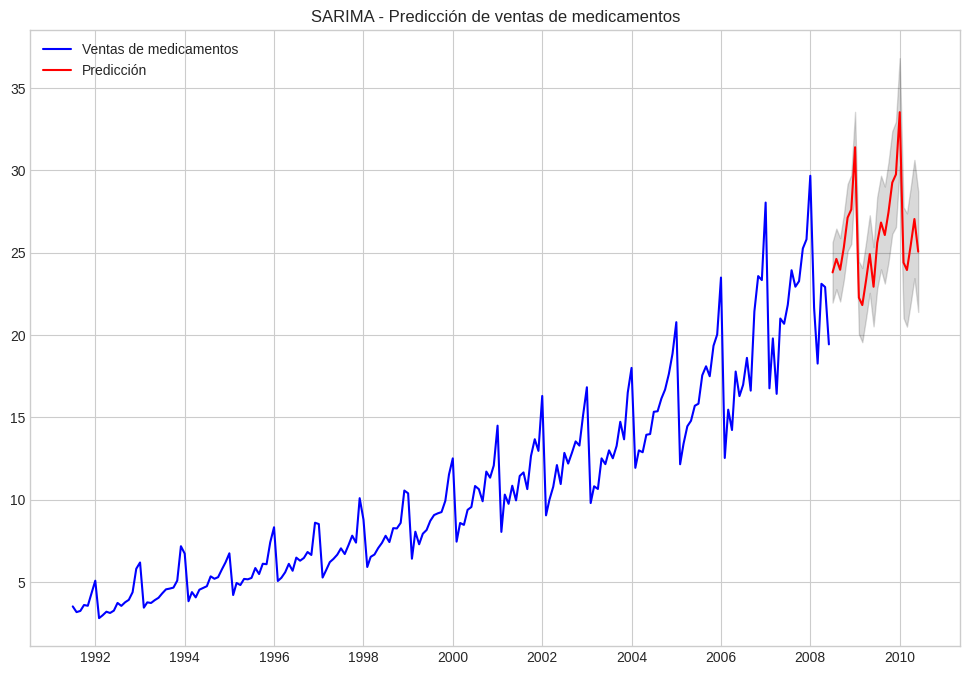

In [79]:
modelo_fut = StatsForecast(models=[AutoARIMA(season_length=12)],freq='MS')  # Indicamos que son datos sin estacionalidad y la frecuencia es "months start"
modelo_fut.fit(medic)
forecast_df2=modelo_fut.predict(h=24, level=[95])
forecast_df2.set_index(forecast_df2.ds, drop=False, inplace=True )

# Gráfico
fig,ax=plt.subplots(figsize=(12,8))
ax.plot(medic['y'], label="Ventas de medicamentos", color="b") #con [-60:] evito representar la serie completa
ax.plot(forecast_df2['AutoARIMA'], label="Predicción", color='r')
ax.fill_between(forecast_df2.index,
                 forecast_df2['AutoARIMA-lo-95'],
                 forecast_df2['AutoARIMA-hi-95'],
                 color='k', alpha=.15)
ax.legend()
ax.set_title("SARIMA - Predicción de ventas de medicamentos")
plt.show()

### AutoArima con variable exógena:

In [90]:
# Para saber qué modelo se está estimando

modelo = StatsForecast(models=[ARIMA(order=(1,0,1), seasonal_order=(1,1,0), season_length=12)],freq='MS')  # Indicamos que son datos sin estacionalidad y la frecuencia es "months start"
modelo.fit(train)
print ("Especificación del modelo: ",modelo.fitted_[0,0].model_['arma'])
print ("Observations",modelo.fitted_[0,0].model_['nobs'])
print ("AIC: ",modelo.fitted_[0,0].model_['aic'])
print ("Coeficientes: ")
for x in modelo.fitted_[0,0].model_['coef']:
  print("  ", x, ":", modelo.fitted_[0,0].model_['coef'][x])

Especificación del modelo:  (1, 1, 1, 0, 12, 0, 1)
Observations 168
AIC:  678.7244558453635
Coeficientes: 
   ar1 : 0.7618429809290084
   ma1 : -0.8293513749991503
   sar1 : -0.16362855417406494


In [85]:
from statsforecast.models import ARIMA